### Wikidata Knowledge Graph Extraction

Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs (KGs) as an external source of information. We found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's not possible to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps covered are:

How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
How to find surrounding entities and descriptions for an entity

In [1]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
print("System version: {}".format(sys.version))

import papermill as pm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from reco_utils.dataset import movielens

from reco_utils.dataset.wikidata import (search_wikidata, 
                                         find_wikidata_id, 
                                         query_entity_links, 
                                         read_linked_entities,
                                         query_entity_description)

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:18:16) [MSC v.1916 64 bit (AMD64)]


In [56]:
names = ['Snacks', 'Love for food', 'Fitness', 'Delicacies', 'Munch', 'coconut', 'healthy oils',
                 'Keto', 'tortilla', 'natural', 'organic', 'chips',
         'fruit', 'wine', 'drink', 'protein', 'bokksu', 'potato',
        'chutney', 'peach', 'delicious', 'chef', 'gourmet', 'recommendation', 'reviews', 'restaurant', 'choclate', 'cake']

In [57]:
%%time

# the following code has been wrapped in a helper function called search_wikidata()
# it is provided here to show the details of which calls are being made to wikipedia APIs

# capture results as a list of dicts to transform to DataFrame (this is faster than appending to DataFrames)
results_list = []
for idx, name in enumerate(names):
    # first get the wikipedia entity_id for each name
    entity_id = find_wikidata_id(name)
    if entity_id == "entityNotFound":
        continue

    # next we query wikipedia to get entity links
    json_links = query_entity_links(entity_id)

    # the following function extracts entities from the links
    related_links = read_linked_entities(json_links)

    # now we can construct an connection in our graph between two entities
    for related_entity, related_name in related_links:
        result = dict(
            name=name,
            original_entity=entity_id,
            linked_entities=related_entity,
            name_linked_entities=related_name,
        )
        results_list.append(result)

results_list = pd.DataFrame(results_list)
results_list

ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND
ERROR - ENTITY NOT FOUND


Wall time: 19.5 s


,name,original_entity,linked_entities,name_linked_entities
0,Snacks,Q749316,Q2526716,list of snacks in alphabetical order by type a...
1,Snacks,Q749316,Q2095,food
2,Snacks,Q749316,Q2095,food
3,Snacks,Q749316,Q7213610,Category:Snack foods
4,Snacks,Q749316,Q749316,snack
...,...,...,...,...
226,cake,Q13276,Q13270,biscuit
227,cake,Q13276,Q5159627,confection
228,cake,Q13276,Q7214152,Category:Cakes
229,cake,Q13276,Q13276,cake


### Visualize KG using networkx

In [58]:
G = nx.from_pandas_edgelist(results_list, 'original_entity', 'linked_entities')

In [59]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

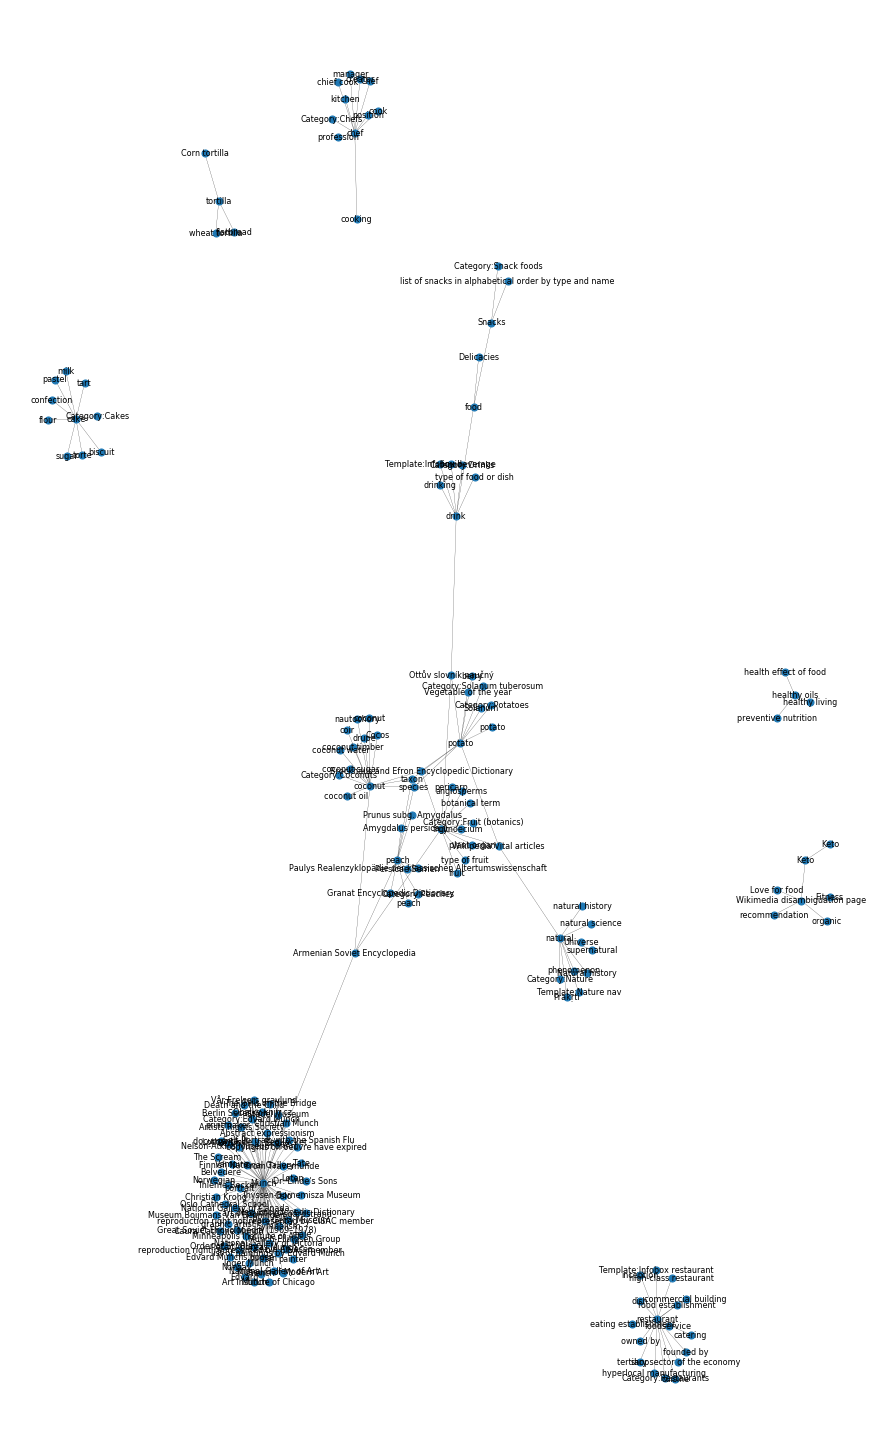

In [60]:
plt.figure(figsize=(12,20)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=50,font_size=8, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=8)
plt.show()